<a href="https://colab.research.google.com/github/rein55/CNN-on-Garbage-Classification/blob/main/Convolutional_Neural_Network_on_Garbage_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Unzip dataset

In [ ]:
import zipfile

# TODO: define zip and dataset name. Dataset path should be: Bird dataset
zip_path = "Garbage classification.zip"
#dataset_path = "Garbage classification"

# TODO: extract data from zip file. Use zip_ref.extractall(dataset_path)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

## Delete Unimportant File

In [ ]:
import shutil

# Tentukan folder yang ingin dihapus
folder_path = "garbage classification"

# Hapus folder beserta isinya
shutil.rmtree(folder_path)

print(f"Folder {folder_path} dan isinya telah dihapus.")


Folder garbage classification dan isinya telah dihapus.


In [ ]:
import os

# Tentukan direktori tempat file diekstrak (misalnya, direktori kerja saat ini)
current_directory = os.getcwd()

# Loop untuk mencari dan menghapus file dengan ekstensi .txt di direktori ini
for file in os.listdir(current_directory):
    if file.endswith(".txt"):
        file_path = os.path.join(current_directory, file)
        os.remove(file_path)
        print(f"File {file} telah dihapus.")


File one-indexed-files-notrash_train.txt telah dihapus.
File one-indexed-files-notrash_val.txt telah dihapus.
File zero-indexed-files.txt telah dihapus.
File one-indexed-files.txt telah dihapus.
File one-indexed-files-notrash_test.txt telah dihapus.


Notes : Karena hasil dari extract terdapat double file yaitu Garbage classification dan garbage classification. Maka dipilih Garbage classification dan garbage classification dihapus dari file directory. file-file txt juga dihapus karena tidak digunakan.

## Check Duplicate Files

In [ ]:
import os

# Tentukan path utama tempat folder-folder tersebut berada
dataset_path = "Garbage classification/Garbage classification"

# Set untuk melacak nama file .jpg yang sudah ditemukan
found_files = set()
duplicates = []

# Daftar subfolder
subfolders = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]

# Loop untuk memeriksa setiap subfolder di dalam dataset_path
for subfolder in subfolders:
    subfolder_path = os.path.join(dataset_path, subfolder)

    # Mengecek apakah path tersebut adalah folder
    if os.path.isdir(subfolder_path):
        # Loop untuk memeriksa setiap file di dalam subfolder
        for file in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path, file)
            # Mengecek apakah nama file sudah ada sebelumnya
            if file in found_files:
              duplicates.append(file_path)  # Jika duplikat, simpan path-nya
            else:
              found_files.add(file)  # Jika tidak, tambahkan ke set

# Tampilkan duplikat yang ditemukan
if duplicates:
    print("File duplikat berdasarkan nama ditemukan:")
    for file in duplicates:
        print(file)
else:
    print("Tidak ada file duplikat berdasarkan nama.")


Tidak ada file duplikat berdasarkan nama.


### Split the dataset to train, val, and test folders

In [ ]:
import os
from pathlib import Path
import shutil

# TODO: read and understand the following code. This code rearrange the
# location of the images. Pay attention to before and after condition

def set_up_dataset_folders(train_size: float = 0.6, validation_size: float = 0.2):
    class_names = [name for name in os.listdir(dataset_path)
                   if os.path.isdir(os.path.join(dataset_path, name))
                   and name not in ["train", "validation", "test"]
                   and name != ".ipynb_checkpoints"]

    for class_name in class_names:
        class_path = Path(dataset_path) / class_name
        filenames = sorted(class_path.iterdir())
        train_max_idx = int(train_size*len(filenames))
        val_max_idx = int((train_size+validation_size)*len(filenames))

        split_files = {"train": filenames[:train_max_idx],
                       "validation": filenames[train_max_idx:val_max_idx],
                       "test": filenames[val_max_idx:]}

        for split, files in split_files.items():
            split_class_dir = Path(dataset_path) / split / class_name
            split_class_dir.mkdir(parents=True, exist_ok=True)

            for file in files:
                shutil.copy2(file, split_class_dir / file.name)

In [ ]:
# TODO: rearrange the image locations. Use training, val, test split: 60:20:20
set_up_dataset_folders(train_size=0.6, validation_size=0.2)

In [ ]:
import os

# Tentukan path utama tempat folder-folder tersebut berada
dataset_path = "Garbage classification/Garbage classification/train"

# Daftar nama subfolder yang ingin diperiksa
subfolders = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]

# Loop untuk memeriksa setiap subfolder dan menghitung jumlah file di dalamnya
for subfolder in subfolders:
    folder_path = os.path.join(dataset_path, subfolder)

    # Mengecek apakah folder ada dan menghitung jumlah file di dalamnya
    if os.path.exists(folder_path):
        file_count = len(os.listdir(folder_path))
        print(f"Jumlah file di folder {subfolder}: {file_count}")
    else:
        print(f"Folder {subfolder} tidak ditemukan.")


Jumlah file di folder cardboard: 241
Jumlah file di folder glass: 300
Jumlah file di folder metal: 246
Jumlah file di folder paper: 356
Jumlah file di folder plastic: 289
Jumlah file di folder trash: 82


Notes : Terdapat imbalance data pada folder trash. Maka dilakukan Handling Imbalance data terlebih dahulu.

## Handling Imbalance Dataset with Oversampling (Trash Folder)

In [ ]:
import os
import random
import shutil
import tensorflow as tf

# Tentukan direktori utama tempat folder-folder tersebut berada
dataset_path = "Garbage classification/Garbage classification/train"

# Setup ImageDataGenerator untuk augmentasi data (oversampling)
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,      # Rotasi gambar secara acak
    width_shift_range=0.2,  # Geser gambar secara acak
    height_shift_range=0.2, # Geser gambar secara acak
    shear_range=0.2,        # Persentase shear (penggeseran gambar)
    zoom_range=0.2,         # Zoom gambar secara acak
    horizontal_flip=True,   # Flip horizontal gambar
    fill_mode='nearest'     # Mengisi piksel kosong setelah transformasi
)

# Folder kelas minoritas yang ingin dilakukan oversampling
minority_class_folder = "trash"

# Tentukan path untuk folder kelas minoritas
minority_class_path = os.path.join(dataset_path, minority_class_folder)

# Mengecek apakah path folder ada
if os.path.isdir(minority_class_path):
    print(f"Oversampling folder: {minority_class_folder}")

    # Loop untuk setiap gambar di dalam folder kelas minoritas
    for file in os.listdir(minority_class_path):
        file_path = os.path.join(minority_class_path, file)
        # Baca gambar dan ubah ke array numpy
        img = tf.keras.preprocessing.image.load_img(file_path)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = img_array.reshape((1,) + img_array.shape)  # Format batch (1, height, width, channels)

        # Lakukan augmentasi (oversampling) untuk menghasilkan gambar baru
        i = 0
        for batch in datagen.flow(img_array, batch_size=1, save_to_dir=minority_class_path, save_prefix='aug', save_format='jpeg'):
          i += 1
          if i > 2:
            break
    print(f"Oversampling selesai pada folder {minority_class_folder}.")


Oversampling folder: trash
Oversampling selesai pada folder trash.


In [ ]:
import os

# Tentukan path utama tempat folder-folder tersebut berada
dataset_path = "Garbage classification/Garbage classification/train"

# Daftar nama subfolder yang ingin diperiksa
subfolders = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]

# Loop untuk memeriksa setiap subfolder dan menghitung jumlah file di dalamnya
for subfolder in subfolders:
    folder_path = os.path.join(dataset_path, subfolder)

    # Mengecek apakah folder ada dan menghitung jumlah file di dalamnya
    if os.path.exists(folder_path):
        file_count = len(os.listdir(folder_path))
        print(f"Jumlah file di folder {subfolder}: {file_count}")
    else:
        print(f"Folder {subfolder} tidak ditemukan.")


Jumlah file di folder cardboard: 241
Jumlah file di folder glass: 300
Jumlah file di folder metal: 246
Jumlah file di folder paper: 356
Jumlah file di folder plastic: 289
Jumlah file di folder trash: 322


Notes : Setelah dilakukan Handling Imbalance Data maka jumlah file lebih balance dalam folder train

In [ ]:
import os

len(os.listdir("Garbage classification/Garbage classification/train/cardboard"))

241

## Data preprocessing

### Split data into train, validation, and test

In [ ]:
import tensorflow as tf


IMAGE_SIZE = 224
BATCH_SIZE = 32

# TODO: learn how to build a dataset generator. Try print next(train_datagen) and see what happens
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                vertical_flip=True,
                                                                horizontal_flip=True)
train_path = "Garbage classification/Garbage classification/train"
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_path = "Garbage classification/Garbage classification/validation"
val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# TODO: build test dataset. Follow the example of validation data generator
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_path = "Garbage classification/Garbage classification/test"
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1754 images belonging to 6 classes.
Found 505 images belonging to 6 classes.
Found 508 images belonging to 6 classes.


In [ ]:
for features, labels in train_generator:
    print(features.shape)
    print(labels.shape)
    break

(32, 224, 224, 3)
(32, 6)


### Show sample dataset

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# TODO: read the following code to show the images and the corresponding labels
def show_samples(split_type: str):
    generators = {"train": train_generator,
                  "val": val_generator,
                  "test": test_generator}
    generator = generators[split_type]
    x_batch, y_batch = next(generator)
    class_labels = list(generator.class_indices.keys())

    # Plot a few images
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        axes[i].imshow(x_batch[i])
        axes[i].axis('off')

        label_idx = np.where(y_batch[i]==1)
        label = class_labels[label_idx[0][0]]  # Convert the label index to the class name

        # Display the label on the image
        axes[i].set_title(f"{label}", fontsize=12)
    plt.show()

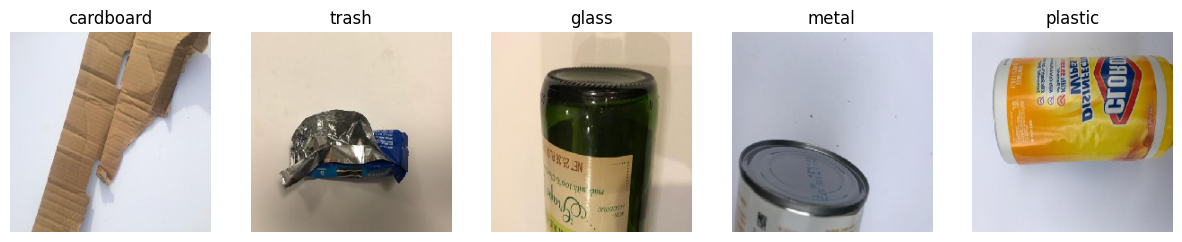

In [ ]:
# TODO: show samples of train, val, and test datasets
show_samples("train")

## Self built CNN model

### Build the model

In [ ]:
# TODO: build CNN models
def create_cnn_model(input_shape=(224, 224, 3), num_classes=6):
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        # Convolutional Layers
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),

        # Flatten and fully connected layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer = 'l2'),#, kernel_regularizer = 'l2'
        tf.keras.layers.Dense(num_classes, activation='softmax')  # Output layer with softmax
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# TODO: Create the model
model = create_cnn_model()

# # TODO: Print model summary
model.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_63 (Conv2D)                   │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_63 (MaxPooling2D)      │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_64 (Conv2D)                   │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_64 (MaxPooling2D)      │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_65 (Conv2D)                   │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_65 (MaxPooling2D)      │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_21 (Flatten)                 │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 64)                  │       3,211,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,235,302 (12.34 MB)

 Trainable params: 3,235,302 (12.34 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# TODO: check weight ratio dense vs convolutions
conv_params = 0
dense_params = 0
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        conv_params += layer.count_params()

In [ ]:
model.layers[0].get_weights()[0].shape

(3, 3, 3, 16)

## Train and evaluation

In [ ]:
# TODO: Train and evaluate the model. Make sure to use GPU
with tf.device('/GPU:0'):
    self_built_history = model.fit(
        train_generator,
        epochs=50,
        validation_data=val_generator,
        verbose=2
    )

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")

Epoch 1/50
55/55 - 11s - 198ms/step - accuracy: 0.3529 - loss: 1.9911 - val_accuracy: 0.4495 - val_loss: 1.5593
Epoch 2/50
55/55 - 5s - 84ms/step - accuracy: 0.4487 - loss: 1.5786 - val_accuracy: 0.4475 - val_loss: 1.4818
Epoch 3/50
55/55 - 6s - 109ms/step - accuracy: 0.4601 - loss: 1.5031 - val_accuracy: 0.4574 - val_loss: 1.4877
Epoch 4/50
55/55 - 9s - 168ms/step - accuracy: 0.4772 - loss: 1.4600 - val_accuracy: 0.4634 - val_loss: 1.4497
Epoch 5/50
55/55 - 6s - 102ms/step - accuracy: 0.5097 - loss: 1.4210 - val_accuracy: 0.5248 - val_loss: 1.3574
Epoch 6/50
55/55 - 5s - 83ms/step - accuracy: 0.5148 - loss: 1.3906 - val_accuracy: 0.5030 - val_loss: 1.4082
Epoch 7/50
55/55 - 7s - 119ms/step - accuracy: 0.5399 - loss: 1.3459 - val_accuracy: 0.5366 - val_loss: 1.3142
Epoch 8/50
55/55 - 9s - 163ms/step - accuracy: 0.5502 - loss: 1.3595 - val_accuracy: 0.5287 - val_loss: 1.4087
Epoch 9/50
55/55 - 6s - 105ms/step - accuracy: 0.5553 - loss: 1.3290 - val_accuracy: 0.5901 - val_loss: 1.2676
Ep

In [ ]:
import matplotlib.pyplot as plt

def plot_train_vs_val(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

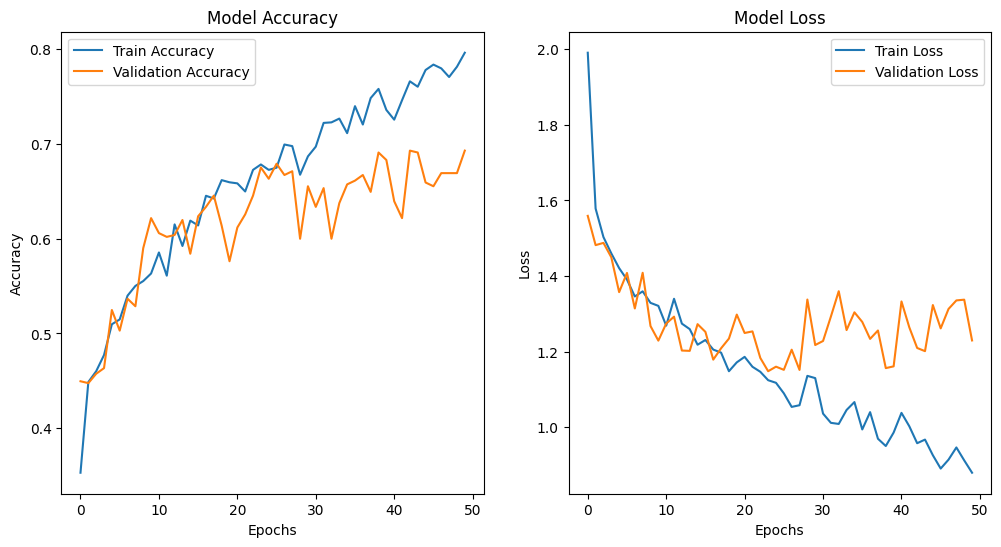

In [ ]:
# TODO: plot historical training data
plot_train_vs_val(self_built_history)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

def plot_confusion_matrix(model):
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Get predicted class labels

    # True labels
    y_true = test_generator.classes

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step


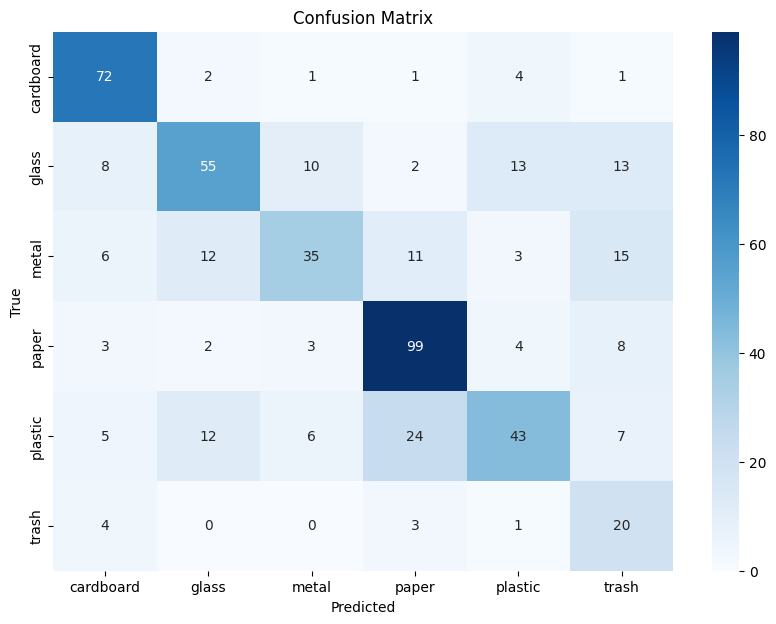

In [ ]:
# TODO: plot the confusion matrix of the trained model
plot_confusion_matrix(model)

Conclusion:

Akurasi validation mencapai 69.31% pada epoch terakhir (epoch ke-50). Meskipun model menunjukkan peningkatan yang signifikan, masih ada gap antara akurasi training (79.65%) dan validation (69.31%). Hal ini bisa menjadi tanda bahwa model mungkin sedikit mengalami overfitting atau masih ada ruang untuk perbaikan dalam generalisasi model.

Pada beberapa titik, seperti antara epoch 15 hingga 30, ada penurunan pada akurasi validation yang mungkin disebabkan oleh fluktuasi dalam pelatihan, namun secara umum, model menunjukkan tren peningkatan.

Pada data test, model mendapatkan akurasi sebesar 63.78%. Ini sedikit lebih rendah dari akurasi validation (69.31%), yang menunjukkan bahwa model masih bisa diperbaiki, terutama dalam hal generalizability pada data yang belum pernah dilihat sebelumnya.

Secara keseluruhan performa model belum bisa dikatakan baik, atau masih kurang bagus, karena akurasi validation (69.31%) dan akurasi test (63.78%) masih di bawah 70% serta ada indikasi overfit pada model.

## Transfer learning

In [ ]:
# TODO: read and understand how to use transfer learning with Keras
def create_transfer_learning_model():
    tl_model = tf.keras.models.Sequential()

    # Add the pre-trained MobileNetV2 model as the base, excluding the top layer
    tl_model.add(tf.keras.applications.MobileNetV2(weights='imagenet',
                                                include_top=False,
                                                input_shape=(224, 224, 3)))

    # Add a Global Average Pooling layer to reduce the spatial dimensions
    tl_model.add(tf.keras.layers.GlobalAveragePooling2D())

    # Add a fully connected layer for classification
    tl_model.add(tf.keras.layers.Dense(1024, activation='relu'))


    # Add the final classification layer (for 6 classes in your case)
    tl_model.add(tf.keras.layers.Dense(6, activation='softmax'))

    # Freeze the base model layers to retain learned features
    tl_model.layers[0].trainable = False

    # Compile the model
    tl_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss='categorical_crossentropy', metrics=['accuracy'])

    return tl_model

In [ ]:
# TODO: train the model
tl_model = create_transfer_learning_model()
tl_history = tl_model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    verbose=2
)

# Evaluate the model on the test dataset
test_loss, test_acc = tl_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")

Epoch 1/5
55/55 - 17s - 313ms/step - accuracy: 0.5867 - loss: 1.1136 - val_accuracy: 0.7960 - val_loss: 0.6916
Epoch 2/5
55/55 - 6s - 117ms/step - accuracy: 0.8079 - loss: 0.5817 - val_accuracy: 0.8079 - val_loss: 0.5625
Epoch 3/5
55/55 - 5s - 92ms/step - accuracy: 0.8540 - loss: 0.4488 - val_accuracy: 0.8356 - val_loss: 0.5049
Epoch 4/5
55/55 - 6s - 110ms/step - accuracy: 0.8888 - loss: 0.3652 - val_accuracy: 0.8257 - val_loss: 0.4862
Epoch 5/5
55/55 - 9s - 165ms/step - accuracy: 0.9173 - loss: 0.3077 - val_accuracy: 0.8396 - val_loss: 0.4595
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.8456 - loss: 0.5307
Test accuracy: 0.7815


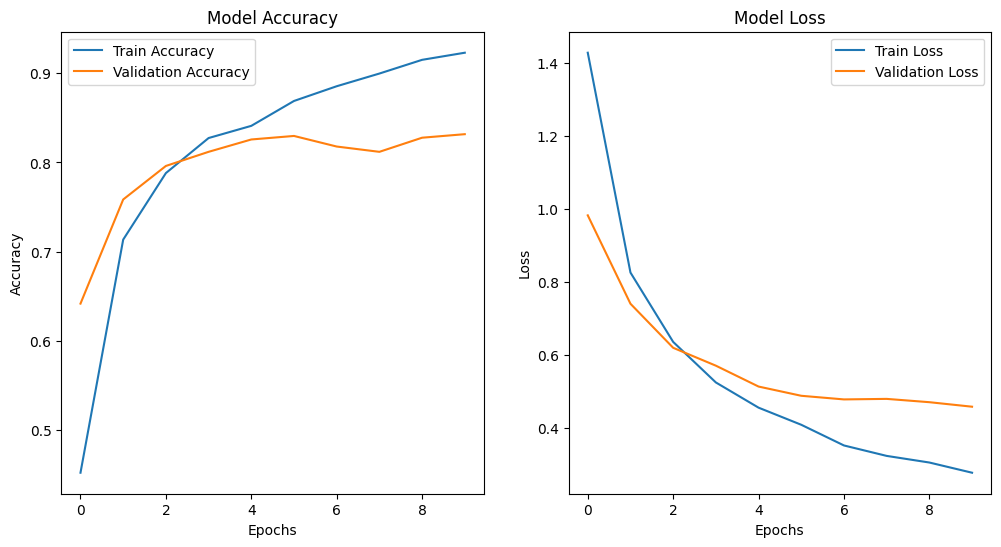

In [ ]:
# TODO: plot training and validation history
plot_train_vs_val(tl_history)

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 248ms/step


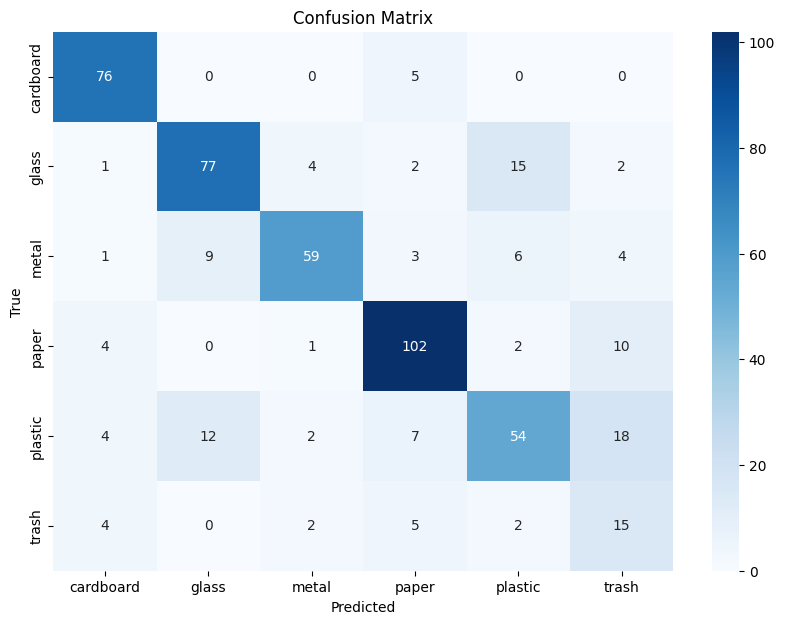

In [ ]:
# TODO: plot confusion matrix of the transfer learning model
plot_confusion_matrix(tl_model)

Conclusion:

Perbandingan Akurasi Sebelumnya dan Setelah Transfer Learning:
Hasil Sebelumnya (tanpa Transfer Learning):

1. Training Accuracy: 79.65% (Epoch 50)
2. Validation Accuracy: 69.31% (Epoch 50)
3. Test Accuracy: 63.78%

Hasil Setelah Transfer Learning:

1. Training Accuracy: 91.73% (Epoch 5)
2. Validation Accuracy: 83.96% (Epoch 5)
3. Test Accuracy: 78.15%

Test Accuracy setelah transfer learning adalah 78.15%, yang lebih tinggi dibandingkan dengan 63.78% tanpa transfer learning. Meskipun masih ada gap dengan akurasi training, peningkatan ini menunjukkan bahwa transfer learning berhasil memperbaiki kemampuan model dalam memprediksi data yang belum pernah dilihat sebelumnya.

Secara keseluruhan, transfer learning terbukti sangat efektif untuk meningkatkan performa model CNN. Hasilnya menunjukkan peningkatan yang signifikan dalam hal akurasi training, validation, dan test dibandingkan dengan model tanpa transfer learning. Meskipun ada sedikit gap antara akurasi training dan test, transfer learning telah mempercepat konvergensi dan meningkatkan kemampuan model untuk menggeneralisasi pada data yang tidak terlihat sebelumnya. Dengan akurasi validation (83.96%) dan akurasi test (78.15%) menunjukkan performa model sudah **cukup baik** setelah dilakukan transfer learning.